# Домашнее задание №4

**1. (20 баллов)**

Для папки Corel необходимо для каждого изображения, предварительно переведенного в HSV, посчитать гистограмму 
(шаг квантования выберите самостоятельно). 
После этого вычислить попарные расстояния между гистограммами с помощью метрик L2 и Хи-квадрат.
Отсортировать полученные пары и записать имена и расстояния в файл (для каждой метрики свой, 
т.е. в конечном итоге будет два файла) в формате:
$$
img\_name1 \hphantom aimg\_name23 \hphantom a 66.3$$
$$
img\_name5 \hphantom aimg\_name66 \hphantom a 77.1,
$$
где в каждой строчке записаны два имени файла и расстояние между изображениями, скрывающимися за этими именами.
Обратите внимание, что тут происходит некоторое определение расстояния между изображениями, 
а значит результат не должен быть совсем уж хаотичным, там есть группы похожих друг на друга изображений.

In [1]:
import numpy as np
import cv2
import matplotlib.pylab as plt
%matplotlib inline

def show(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def show_imgs(imgs):
    if (len(imgs) > 15):
        columns_cnt = 15
    else:
        columns_cnt = len(imgs)
    rows_cnt = len(imgs) // columns_cnt + 1   
        
    fig = plt.figure(figsize=(20,20))
    for count, img in enumerate(imgs):
        a = fig.add_subplot(rows_cnt, columns_cnt, count + 1)
        a.set_axis_off()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))     

In [2]:
import glob
list_of_names = glob.glob("datasets/Corel/*")

dic_of_img = {}
for name in list_of_names:
    img = cv2.imread(name)
    p = name.split('/')
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    dic_of_img[p[2]] = hsv_img

In [3]:
def chi2_distance(histA, histB, eps = 1e-10):
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps) for (a, b) in zip(histA, histB)])
    
    return d

def key_distance(tuple_):
    _, _, d = tuple_
    
    return d

def show_by_names(name1, name2):
    img1 = dic_of_img[name1]
    img2 = dic_of_img[name2]
    
    show_imgs([img1, img2])

In [4]:
dic_histograms = {}
for name in dic_of_img.keys():
    hsv_img = dic_of_img[name]
    hist = cv2.calcHist([hsv_img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    dst = np.zeros_like(hsv_img)
    dst = cv2.normalize(hist, dst).flatten()
    dic_histograms[name] = dst

In [5]:
from scipy.spatial.distance import euclidean
import itertools

chi2_result = []
l2_result = []
all_names = dic_histograms.keys()
all_pairs = list(itertools.combinations(all_names, 2))
for pairs in all_pairs:
    name1, name2 = pairs
    chi2_d = chi2_distance(dic_histograms[name1], dic_histograms[name2])
    l2_d = euclidean(dic_histograms[name1], dic_histograms[name2])
    chi2_result.append((name1, name2, chi2_d))
    l2_result.append((name1, name2, l2_d))

In [6]:
chi2_result.sort(key=key_distance)
l2_result.sort(key=key_distance)

s = ''
with open('Corel_Chi-squared.txt', 'w') as f:
    for name1, name2, d in chi2_result:
        s += name1 + " " + name2 + " " + str(d) + "\n"
    f.write(s)
    
s = ''
with open('Corel_L2.txt', 'w') as f:
    for name1, name2, d in l2_result:
        s += name1 + " " + name2 + " " + str(d) + "\n"
    f.write(s)    

**2. (20 баллов)**
Для папки leaves для каждого контура листа необходимо посчитать дескрипторы Фурье. После этого вычислить попарные расстояния между контурами (используйте метрику L2 для сравнения набора дескрипторов). Отсортировать полученные пары и записать имена в файл в формате, обозначенном в первом пункте.

In [7]:
import glob
list_of_names = glob.glob("datasets/Leaves/*")

dic_of_img = {}
for name in list_of_names:
    img = cv2.imread(name)
    p = name.split('/')
    dic_of_img[p[2]] = img

In [8]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
def findDescriptor_with_dist(img, angle):
    #найдем контур изображения
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray,127,255,0)
    contour = []
    _, contour, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE,contour)
    
    #найдем центр изображения
    list_of_points = contour[0]
    M = cv2.moments(list_of_points)
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
    center_of_mass = [cx, cy]
    
    list_of_distance = []
    
    #зададим угол
    final_cos = np.cos((2 * np.pi / 360) * angle)
    
    #для фурье будем считать расстояние от центра до точки на контуре, прыгая по заданному углу
    i = 0
    N = len(list_of_points)
    point = list_of_points[i]
    tx, ty = point[0]
    vec_old = [tx - cx, ty - cy]
    i = 1
    while(i < N):
        point = list_of_points[i]
        tx, ty = point[0]
        vec_new = [tx - cx, ty - cy]
        #считаем косинус между двумя векторами
        cos_sim = 1 - cosine(vec_old, vec_new)
        if (cos_sim < final_cos):
            list_of_distance.append(euclidean([tx, ty], center_of_mass))
            vec_old = vec_new
        i += 1
    
    #раскладываем в фурье список из расстояний
    fourier_result = np.fft.fft(list_of_distance)

    u_norm = np.absolute(fourier_result)
        
    arr = u_norm / u_norm[0]

    #дополняем до угла в 360 градусов там, где это необходимо
    if (len(arr) < int(360 / angle)):
        arr = np.pad(arr, (0, int(360/ angle) - len(arr)), mode='constant', constant_values=0)
    
    return arr[1:]

In [9]:
dic_descriptors = {}
for name in dic_of_img.keys():
    img = dic_of_img[name]
    d = findDescriptor_with_dist(img, angle = 1)
    dic_descriptors[name] = d

In [10]:
from scipy.spatial.distance import euclidean
import itertools

l2_result = []
all_names = dic_descriptors.keys()
all_pairs = list(itertools.combinations(all_names, 2))
for pairs in all_pairs:
    name1, name2 = pairs
    l2_d = euclidean(dic_descriptors[name1], dic_descriptors[name2])
    l2_result.append((name1, name2, l2_d))
    
l2_result.sort(key=key_distance)    

In [11]:
s = ''
with open('Leaves_L2.txt', 'w') as f:
    for name1, name2, d in l2_result:
        s += name1 + " " + name2 + " " + str(d) + "\n"
    f.write(s)   

Реализуте функцию, которая выводит на экран n самых лучших пар. 

In [18]:
def show_nearest(n, filename, leaves = True):
    if (leaves):
        path = 'datasets/leaves/'
    else:
        path = 'datasets/Corel/'
    with open(filename) as f:
        number = 0
        for i in np.arange(n):
            content = f.readline()
            name1, name2, _ = content.split(' ')
            img1 = cv2.imread(path + name1)
            img2 = cv2.imread(path + name2)
            
            fig = plt.figure(figsize=(10, 20))

            number += 1
            a = fig.add_subplot(n, 2,  number)
            a.set_axis_off()
            plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
                
            number += 1    
            a = fig.add_subplot(n, 2, number)
            a.set_axis_off()
            plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))      

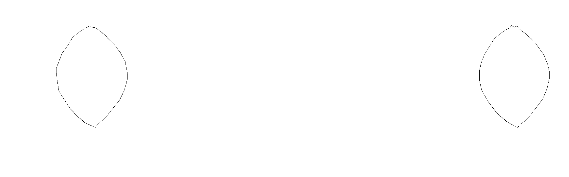

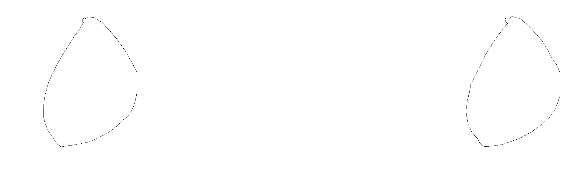

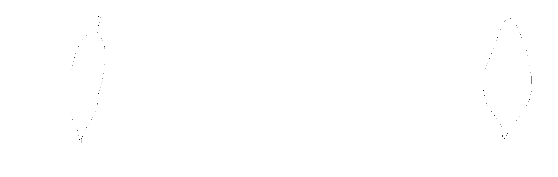

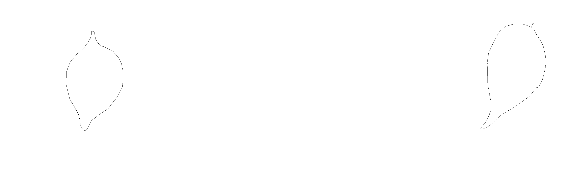

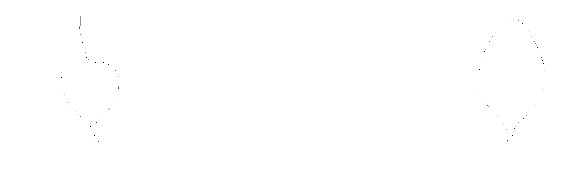

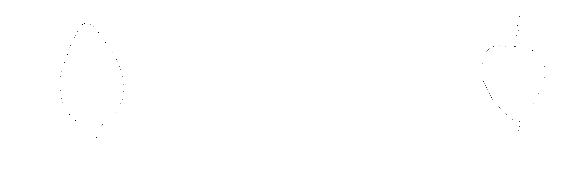

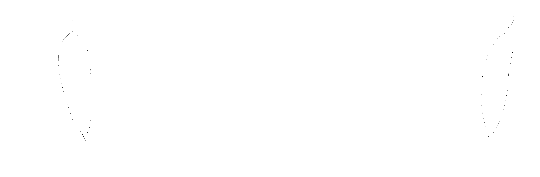

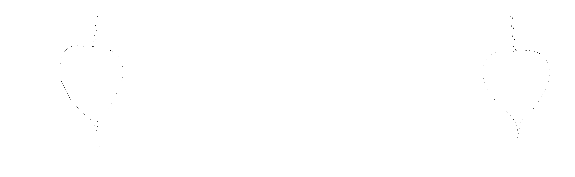

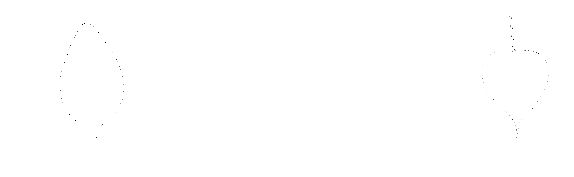

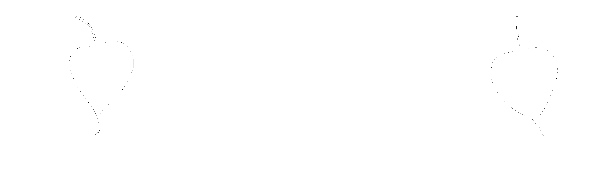

In [19]:
show_nearest(10, 'Leaves_L2.txt')